In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from read_roi import read_roi_zip
import untangle
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sys, os
sys.path.insert(0, os.path.abspath('../utils'))
from MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection, bulk_peak_analysis

# Figure S2 - in vivo

## Dynamics analysis on Looping PSM4 cells

For this, we import the data from 2 embryos where cells were tracked from the PSM4 area. Once the data is organized, we will measure the number of peaks, ratio of slowing down and the dynamics of Mesp onset vs Her 1 last peak. The .csv files were exported from Mastodon where we performed the tracking. 

In [2]:
# Position 1 and 2 correspond to two embryos from the same experiment
position = [1,2]

In [3]:
# Path to .xml file generated when creating the .hdf5
path_xml = ['../Data/Figure S2/Figure S2 - In vivo/Position1_20191213.xml', '../Data/Figure S2/Figure S2 - In vivo/Position2_20191213.xml']

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = ['../Data/Figure S2/Figure S2 - In vivo/Position1', '../Data/Figure S2/Figure S2 - In vivo/Position2']

# Path to roi zip
path_roi = ['../Data/Figure S2/Figure S2 - In vivo/RoiSet-Position1.zip', '../Data/Figure S2/Figure S2 - In vivo/RoiSet-Position2.zip']

### Image characteristics

In [4]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes


for i in range(len(position)):
    exec('fts%d = xml_features(path_xml[i])'%position[i])
    fts = xml_features(path_xml[i])
    
    # Features from the image obtained from the .xml generated by BigData Viewer
    print('Image features from POSITION # %d'%(i+1))
    print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
    print('There are %d frames in total.'%fts.n_frames)
    print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
    print('There are %d Z-slices in total'%fts.n_slices)
    print(' ')

Image features from POSITION # 1
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 
Image features from POSITION # 2
The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total
 


### Organize the data

In [5]:
# Save tracks coming from all experiments

for i in range(len(position)):
    # Function to obtain all the spots' information from the .csv file
    spots = csv_features(path_csv[i], path_xml[i])
    
    # Order the time series according to each individual cell
    exec('tracks%d = ordering_tracks(path_csv[i], path_xml[i])'%position[i])
    

In [6]:
print('Number of cells in embryo 1: %d'%tracks1.n_tracks_divs)
print('Number of cells in embryo 2: %d'%tracks2.n_tracks_divs)
print('Total number of cells: %d'%(tracks1.n_tracks_divs+tracks2.n_tracks_divs))

Number of cells in embryo 1: 28
Number of cells in embryo 2: 103
Total number of cells: 131


### Peak alignment

In [7]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_cells_pos = []
n_frames = 0

for i in range(len(position)):
    n_cells_pos.append(eval('tracks%d.n_tracks_divs'%position[i]))
    if eval('fts%d.n_frames'%position[i])>n_frames:
        n_frames = eval('fts%d.n_frames'%position[i])

n_cells = sum(n_cells_pos)    

# Save all the cells from all the experiments in the same array 
tracks_save = np.ones((n_cells, n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, n_frames))*np.nan
y_save = np.ones((n_cells, n_frames))*np.nan
z_save = np.ones((n_cells, n_frames))*np.nan

count = 0

for k in range(len(position)):
    # Fill the timepoints where there are no cells tracked with nan
    tracks_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # Save also the x,y positions
    x_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    y_aux = np.ones((n_cells_pos[k], n_frames))*np.nan
    z_aux = np.ones((n_cells_pos[k], n_frames))*np.nan

    # For each track 
    for i in range(n_cells_pos[k]):

        # Add the tracked spot to the specific time frame to which it corresponds
        for j,val in enumerate(eval('tracks%d.spots_features["Frames"][i]'%position[k])):
            tracks_aux[i,val] = eval('tracks%d.spots_features["Mean1"][i][j]'%position[k])
            x_aux[i,val] = eval('tracks%d.spots_features["X"][i][j]'%position[k])
            y_aux[i,val] = eval('tracks%d.spots_features["Y"][i][j]'%position[k])
            z_aux[i,val] = eval('tracks%d.spots_features["Z"][i][j]'%position[k])
            
    tracks_save[count:count+n_cells_pos[k],:] = tracks_aux
    x_save[count:count+n_cells_pos[k],:] = x_aux
    y_save[count:count+n_cells_pos[k],:] = y_aux
    z_save[count:count+n_cells_pos[k],:] = z_aux
    
    count += n_cells_pos[k]

In [8]:
print('There are %d cells in vivo'%n_cells)

There are 131 cells in vivo


### Smoothing signal

Apply an averaging window to the data and plot each individual raw track (in black) and the smoothed signal (in dashed blue) to show the smoothing filter is not geting rid of any important part od the trace. 

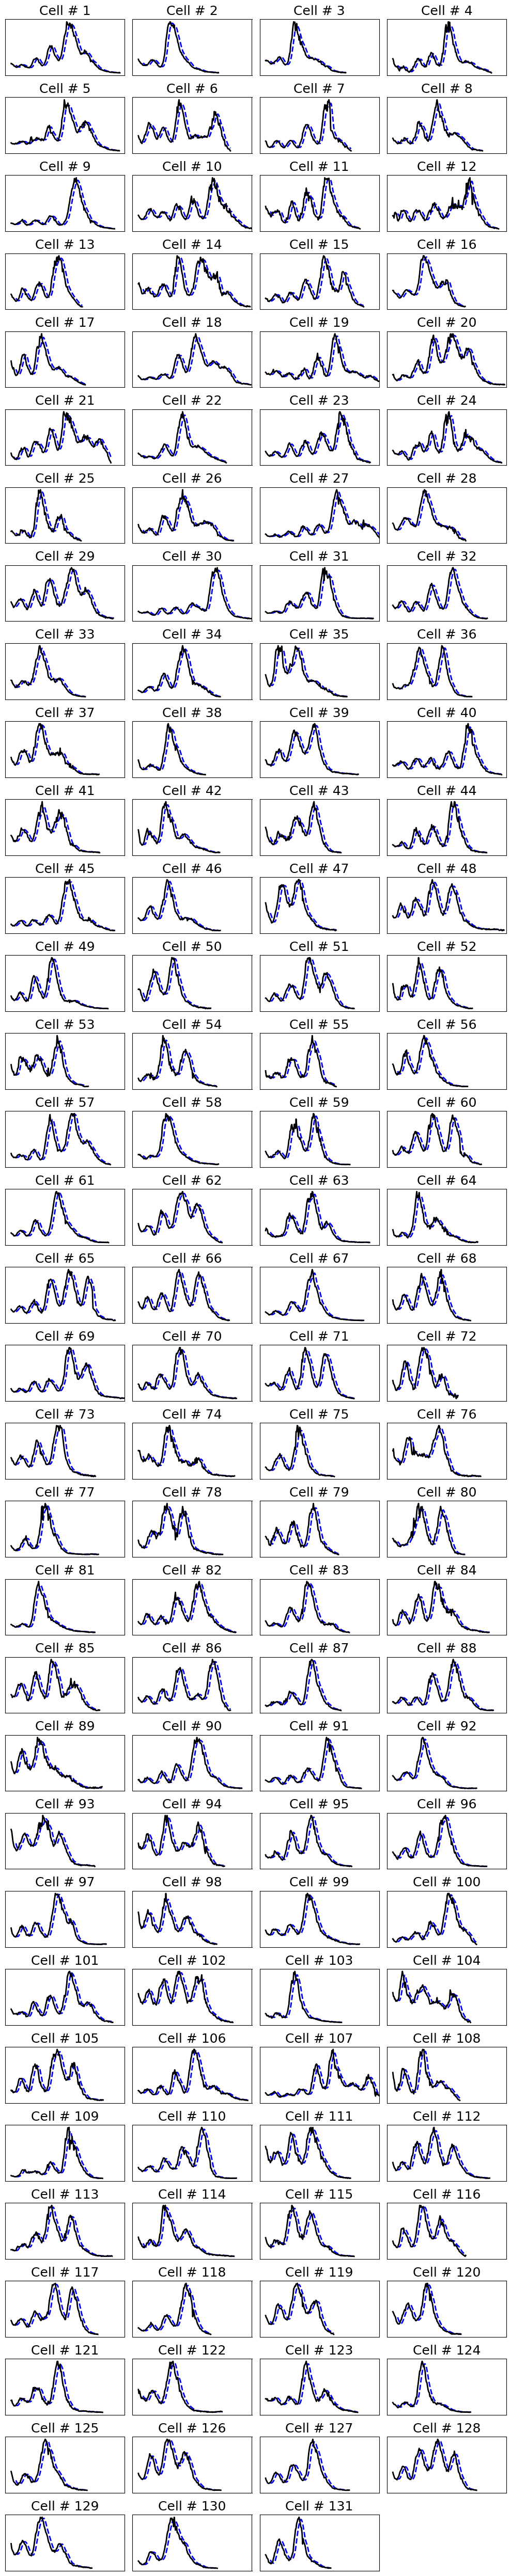

In [9]:
# Averaging window size
window = 9

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

for j in range(n_cells):
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Smoothing filter
    y = smoothing_filter(tracks_save[j], window)

    plt.plot(y, color='blue',linewidth=2, linestyle = 'dashed')
    plt.plot(tracks_save[j],linewidth=2, color='black')
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    locs, labels = plt.xticks()
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,200])

plt.tight_layout()
plt.show()

### Peak deteciton 

In [10]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'no_ts_as'

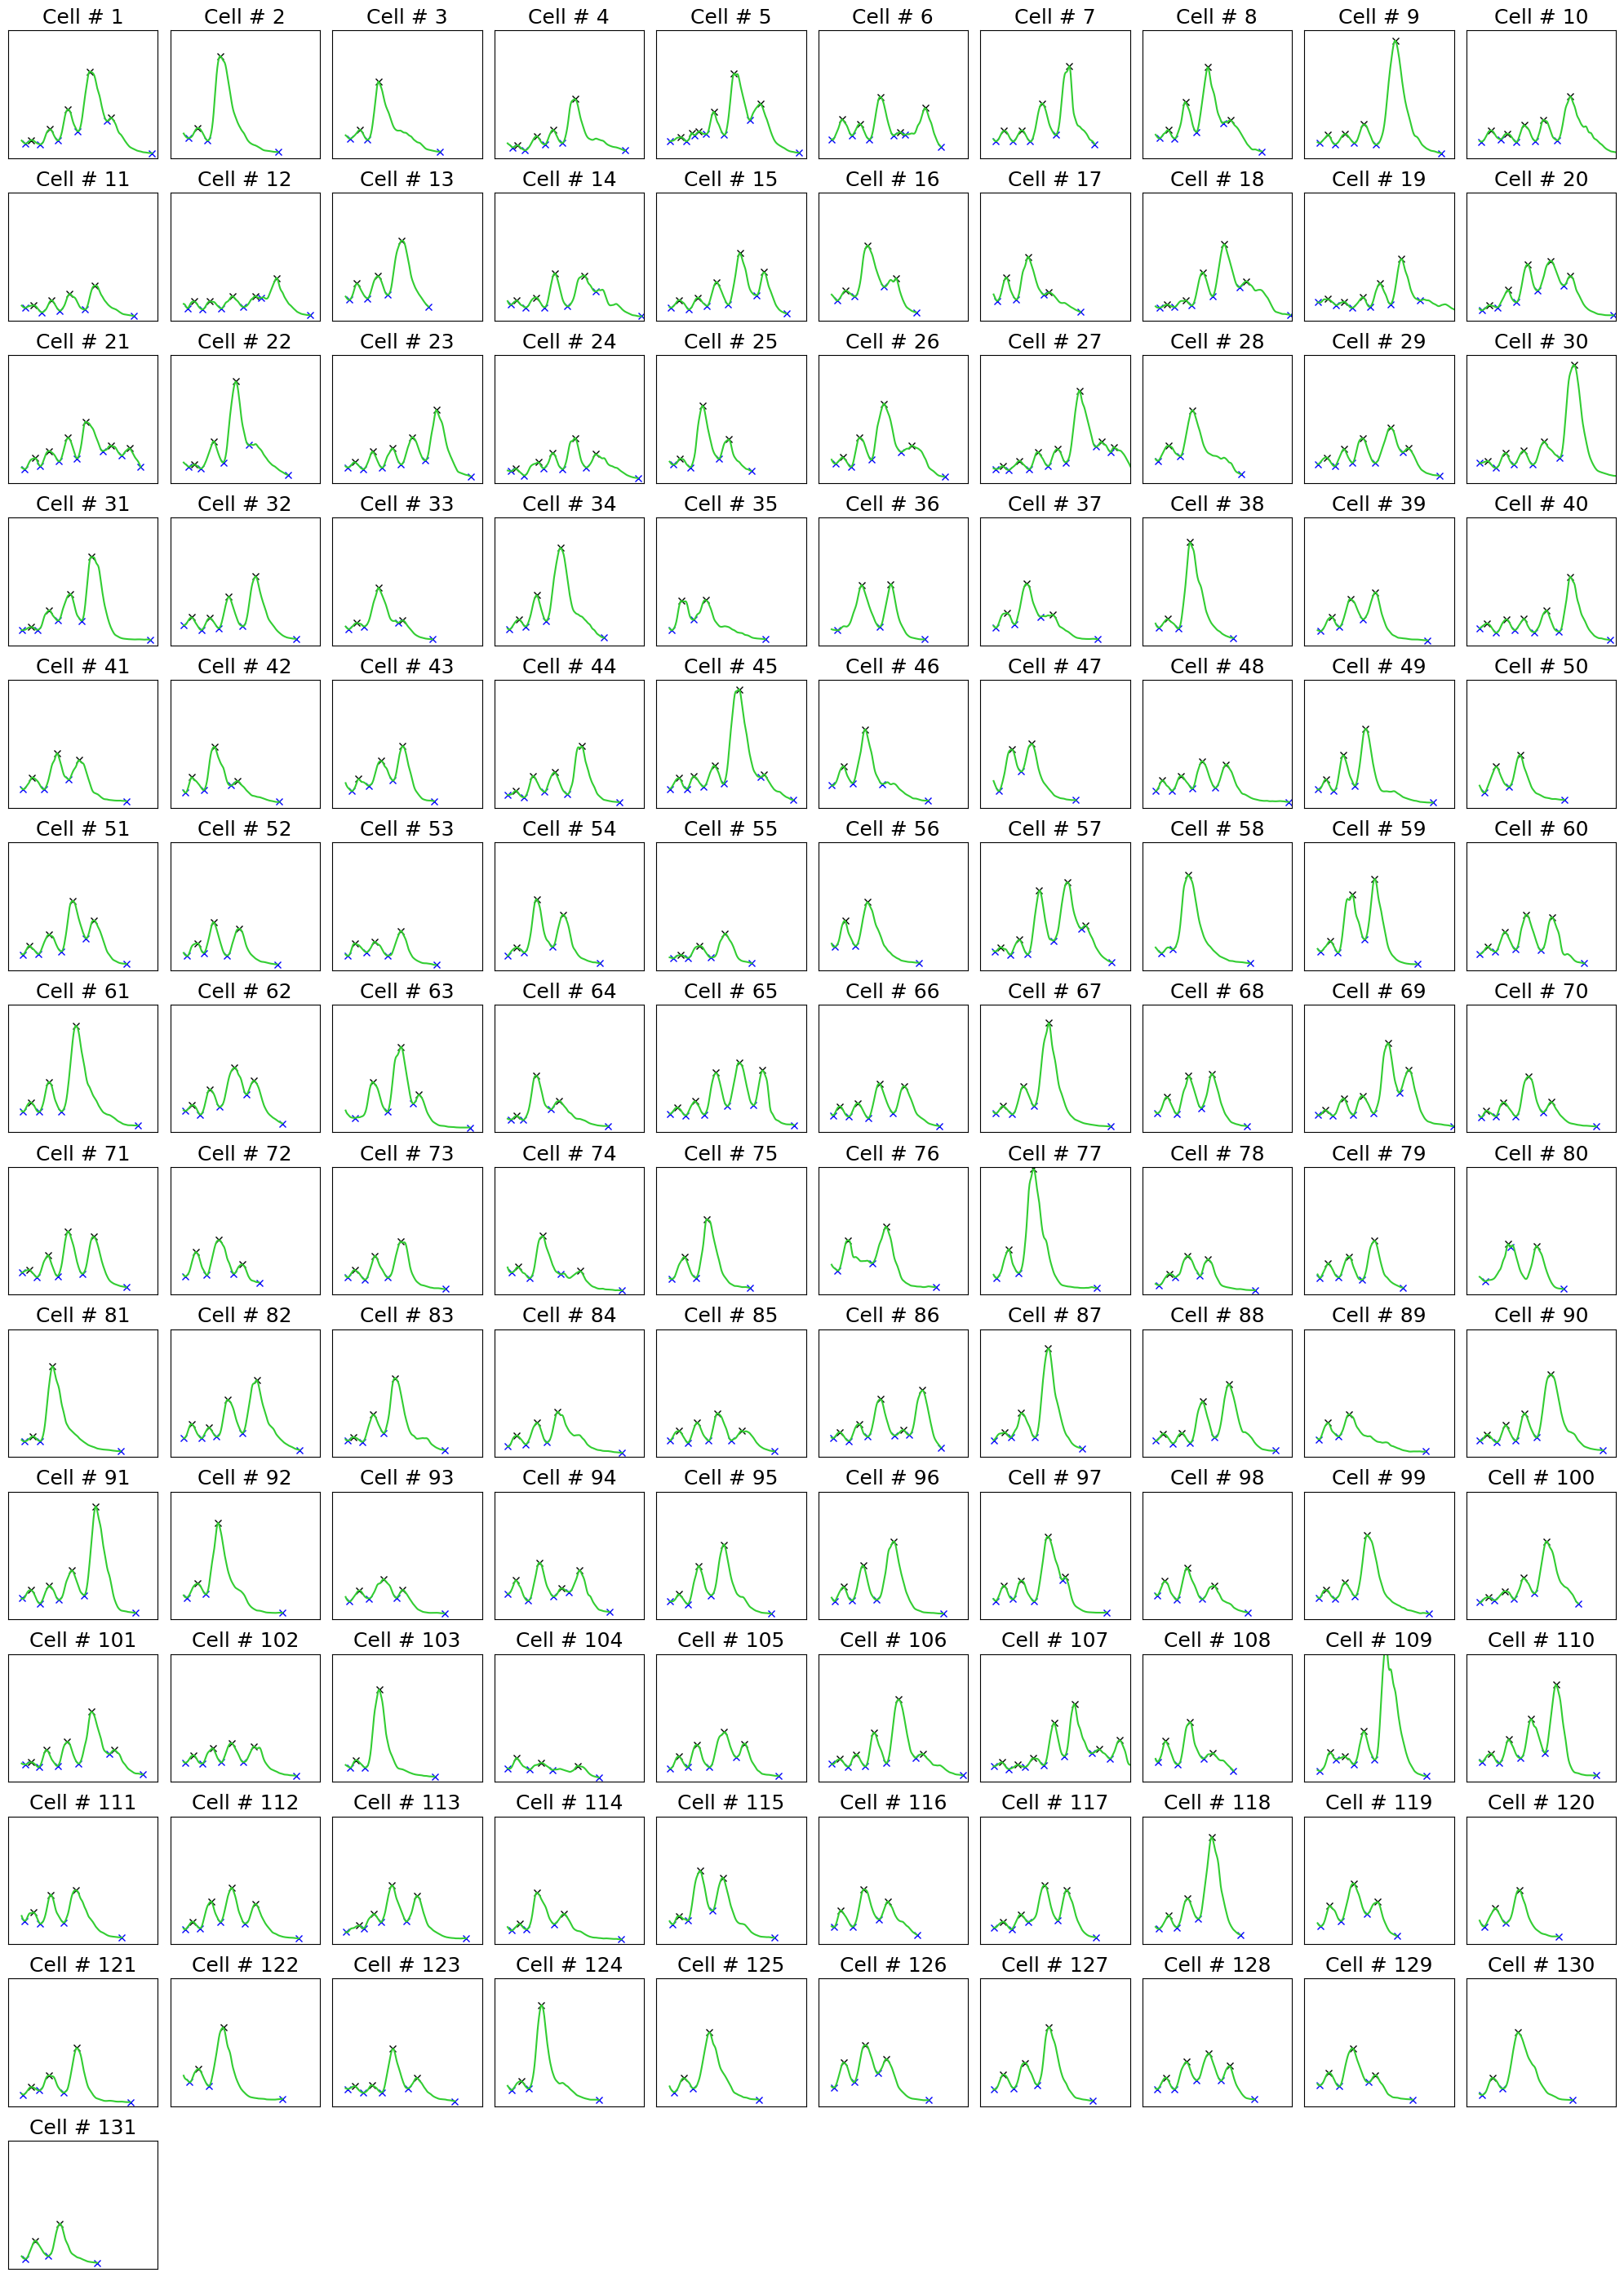

In [11]:
# Define the dimensions of the subplot
n_cols = 10
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

size_fig = n_rows*(20/n_cols)
# Initialize the figure size
fig = plt.figure(figsize=[20,size_fig])

periods = []
amplitudes = []

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    # Save periods, amplitudes
    periods.append(np.diff(peaks.peaks))
    amplitudes.append(y[peaks.peaks])
    
    plt.plot(peaks.peaks, y[peaks.peaks], "xk"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xb"); plt.plot(y, color='limegreen'); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,200])
    plt.ylim([100,600])

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure S2/Figure S2 - In vivo/Results/LoopinPeaksTroughs.pdf', format='pdf', bbox_inches='tight')

## Successive peak ratio vs successive amplitude ratio

In [12]:
ratio_func = lambda x: [x[i+1]/x[i] for i in range(len(x)-1)]

period_s = []
amplitudes_s = []

for i in range(n_cells):
    period_s.append(ratio_func(periods[i]))
    amplitudes_s.append(ratio_func(amplitudes[i][:-1]))

Text(0, 0.5, 'Successive Amplitude Rate')

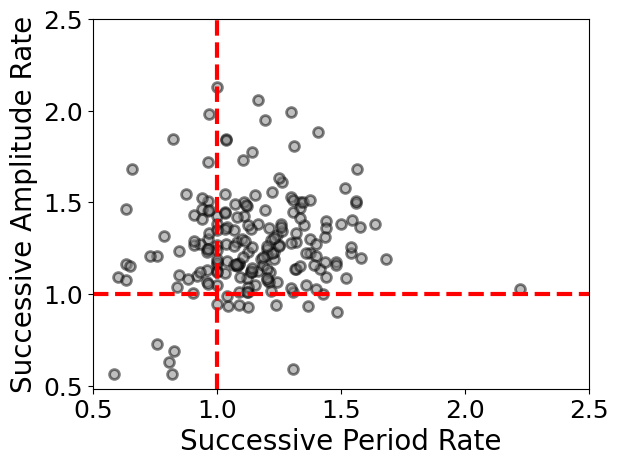

In [13]:
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='gray', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        
plt.axvline(1, linewidth=3, linestyle='dashed', color='red')
plt.axhline(1, linewidth=3, linestyle='dashed', color='red')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

In [14]:
aux = []
for i in range(n_cells):
    aux.append(len(periods[i]))
    
n_peaks = np.unique(aux)

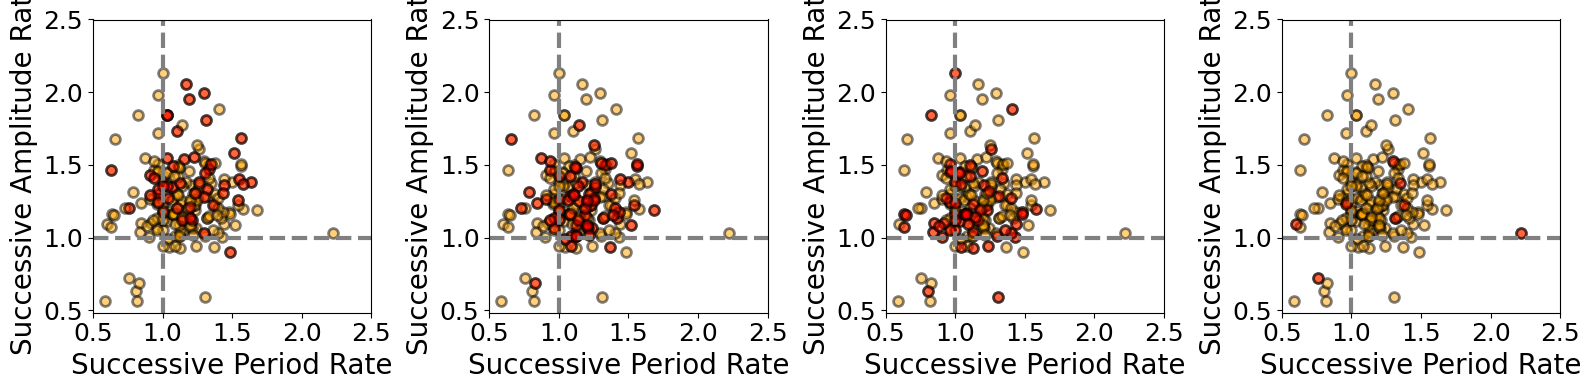

In [15]:
plt.figure(figsize=[16,4])

plt.subplot(141)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==1:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(142)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==2:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(143)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==3:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.subplot(144)
for i in range(n_cells):
    plt.scatter(period_s[i], amplitudes_s[i], color='orange', s=50, linewidth=2, edgecolor='black', alpha=0.5)
for i in range(n_cells):
    if len(period_s[i])==4:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)


plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)


plt.tight_layout()
plt.show()

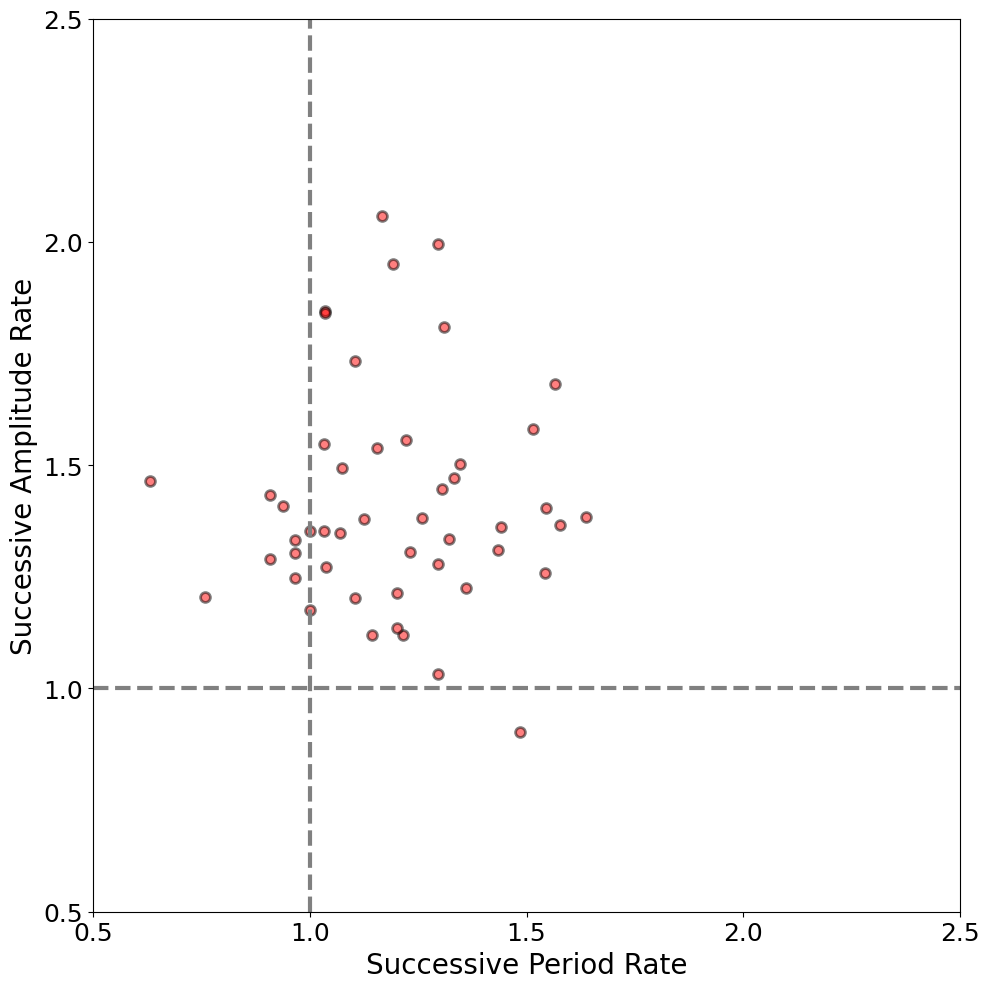

In [16]:
plt.figure(figsize=[10,10])

for i in range(n_cells):
    if len(period_s[i])==1:
        plt.scatter(period_s[i], amplitudes_s[i], color='red', s=50, linewidth=2, edgecolor='black', alpha=0.5)
        plt.plot(period_s[i], amplitudes_s[i], color='k')

plt.axvline(1, linewidth=3, linestyle='dashed', color='gray')
plt.axhline(1, linewidth=3, linestyle='dashed', color='gray')

plt.xticks(np.arange(0.5,3, 0.5), fontsize=18)
plt.yticks(np.arange(0.5,3, 0.5),fontsize=18)

plt.xlabel('Successive Period Rate', fontsize=20)
plt.ylabel('Successive Amplitude Rate', fontsize=20)

plt.tight_layout()
plt.show()

### Heatmaps

There are 4 possible options:

**[ 1 ]** Amplitude and Period successive ratio increases --> score = 1

**[ 2 ]** Amplitude and Period successive ratio decreases --> score = 2

**[ 3 ]** Amplitude successive ratio increases and the period sucessive ratio decreases --> score = 3

**[ 4 ]** Amplitude successive ratio decreases and the period successive ratio increases --> score 4

In [17]:
scores_ratios = []

for i in range(n_cells):
    aux = np.zeros(len(n_peaks)-2)
    for j in range(len(period_s[i])):
        # Add a score according to how the cells are behaving
        if period_s[i][j] > 1 and amplitudes_s[i][j] > 1:
            aux[j] = 1
        if period_s[i][j] < 1 and amplitudes_s[i][j] < 1:
            aux[j] = 2
        if period_s[i][j] > 1 and amplitudes_s[i][j] < 1:
            aux[j] = 4
        if period_s[i][j] < 1 and amplitudes_s[i][j] > 1:
            aux[j] = 3

    scores_ratios.append(aux)

Text(0, 0.5, 'Number of Cells')

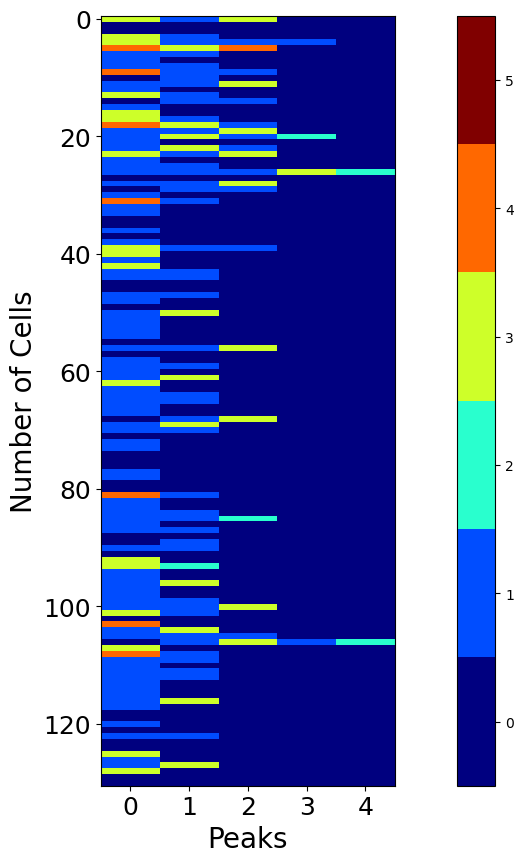

In [20]:
plt.figure(figsize=[16,10])

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    #CH: Comment and change to avoid complaint
    #base = plt.cm.get_cmap(base_cmap)
    base = plt.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

N = max(n_peaks)

plt.imshow(scores_ratios, aspect=0.1, cmap=discrete_cmap(N, 'jet'))

plt.colorbar(ticks=range(N))
plt.clim(-0.5, N - 0.5)

plt.xticks(fontsize=18)
plt.xlabel('Peaks', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Number of Cells', fontsize=20)

### Arrange the scores according to peak number

In [21]:
scores_ratios_peaks = []

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 0:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 1:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux 

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 2:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 3:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

aux = []
for i in range(n_cells):
    if np.count_nonzero(scores_ratios[i]) == 4:
        aux.append(scores_ratios[i])
scores_ratios_peaks += aux  

Text(0, 0.5, 'Number of Cells')

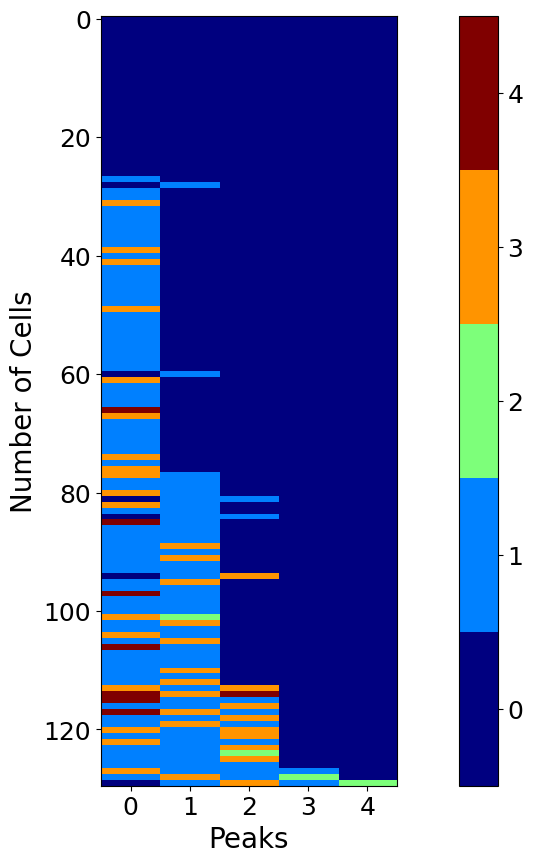

In [23]:
plt.figure(figsize=[16,10])

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.colormaps.get_cmap(base_cmap)
    #CH: changed
    #base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

N = max(n_peaks)-1

plt.imshow(scores_ratios_peaks, aspect=0.1, cmap=discrete_cmap(N, 'jet'))

cbar = plt.colorbar(ticks=range(N))
plt.clim(-0.5, N - 0.5)
cbar.ax.tick_params(labelsize=18)

plt.xticks(fontsize=18)
plt.xlabel('Peaks', fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel('Number of Cells', fontsize=20)

## Analysis with cells exhibiting a shoulder peak vs no shoulder-peak cells

A cell with a shoulder last peak is defined as those cells where the last peak is smaller in amplitude than the second to last peak. 

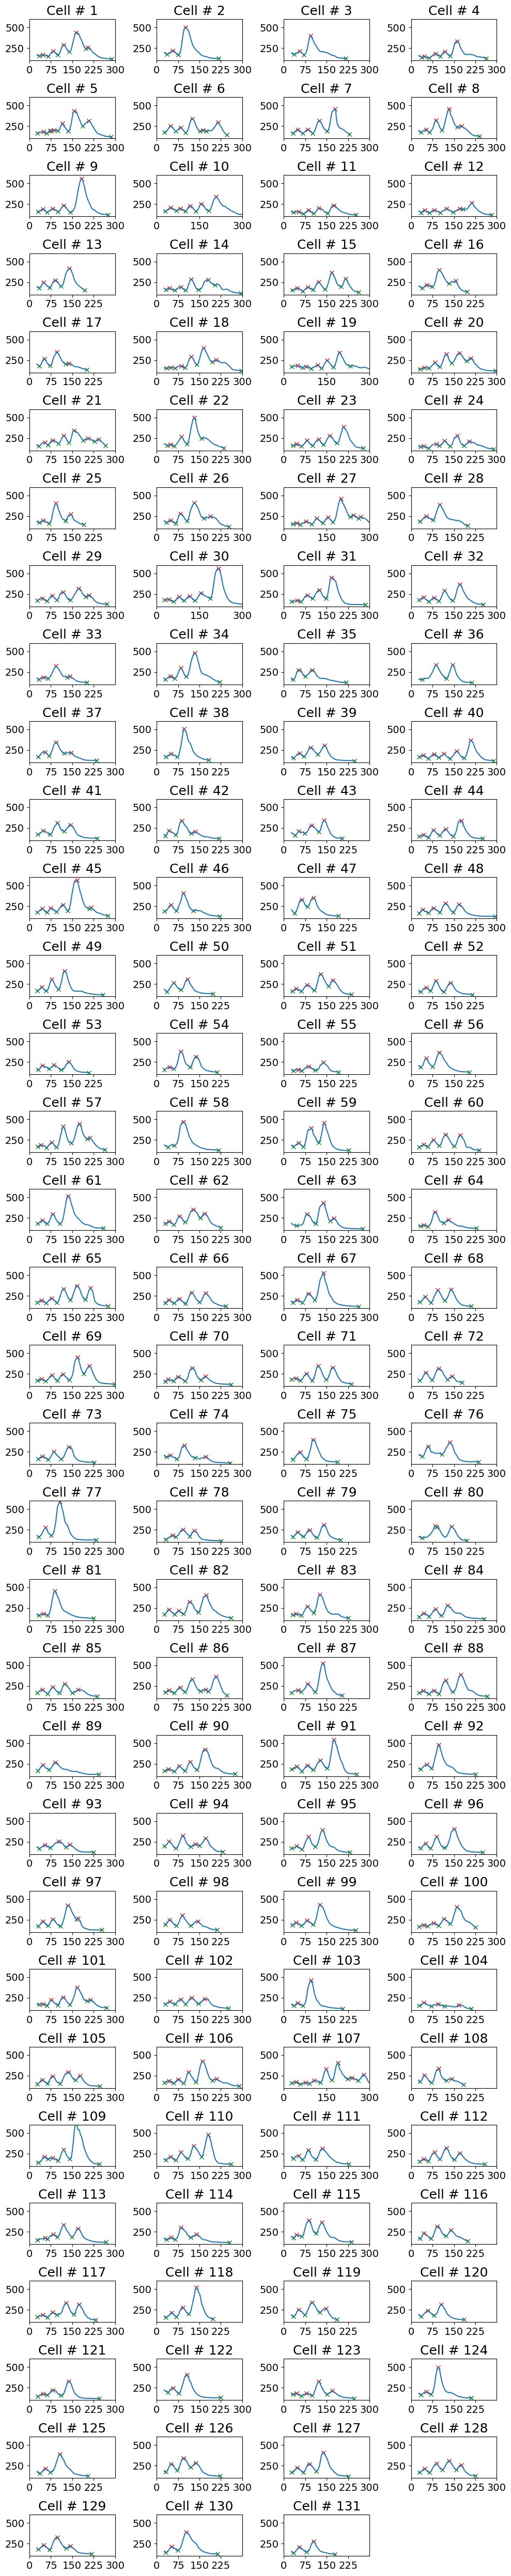

In [28]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'ts_as'

# Define the dimensions of the subplot
n_cols =  4
#CH: Changed
#n_rows = np.ceil((n_cells + 1) / n_cols)
n_rows = int(np.ceil((n_cells + 1) / n_cols))
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

max_peaks_all = []
min_peaks_all = []
max_val_all = []
min_val_all = []
periods_all = []

# To obtain the maximum number of cycles
max_n_cycles = 0

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(n_rows, n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    # Save peaks (in time)
    max_peaks_all.append((peaks.peaks+window/2)*tr_min)
    min_peaks_all.append((peaks.peaks_+window/2)*tr_min)
    
    # Save maxima intensity
    max_val_all.append(y[peaks.peaks])
    
    # Save minima
    min_val_all.append(y[peaks.peaks_][:-1])
    
    # Save periods
    if len(peaks.peaks)>1:
        periods_all.append(np.diff(peaks.peaks)*tr_min)
    
    if len(peaks.peaks)>max_n_cycles:
        max_n_cycles = len(peaks.peaks)
        
    plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    #plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    #plt.ylabel('Mean Intensity', fontsize=16)
    plt.xlim([0,200])
    plt.ylim([100,600])


plt.tight_layout()
plt.show()

In [29]:
shoulder_cells = []
no_shoulder_cells = []


for i in range(n_cells):
    # First check there is at least two peaks:
    if len(amplitudes[i])>1:
        
        # if last amplitude is smaller than the second to last, it is a shoulder
        if amplitudes[i][-1]<amplitudes[i][-2]:
            shoulder_cells.append(i)

        # Otherwise, there is no shoulder
        else:
            no_shoulder_cells.append(i)
    else:
        no_shoulder_cells.append(i)

In [30]:
print('Number of shoulder cells: ', len(shoulder_cells)*100/n_cells)
print('Number of no-shoulder cells: ', len(no_shoulder_cells)*100/n_cells)

Number of shoulder cells:  45.038167938931295
Number of no-shoulder cells:  54.961832061068705


### Min-Max Amplitude values of shoulder cells vs no shoulder cells

In [31]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [32]:
# For cells with shoulders
min_val_cycle_s = {new_list: [] for new_list in range(1,max_n_cycles+1,)}
max_val_cycle_s = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in shoulder_cells:
    # If we have the same number of maxima and minima, then we can compare
    if len(min_val_all[i]) == len(max_val_all[i]):
        # Save the value of each maxima/minim according to the cycle
        for j in range(len(min_val_all[i])):
            min_val_cycle_s[j+1].append(min_val_all[i][j])
            max_val_cycle_s[j+1].append(max_val_all[i][j])
            
# Convert into list arrays  
min_cycle_s = []
max_cycle_s = []

for i in range(max_n_cycles):
    min_cycle_s.append(np.array(min_val_cycle_s[i+1]))
    max_cycle_s.append(np.array(max_val_cycle_s[i+1]))

# For cells without shoulders
min_val_cycle_ns = {new_list: [] for new_list in range(1,max_n_cycles+1,)}
max_val_cycle_ns = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in no_shoulder_cells:
    # If we have the same number of maxima and minima, then we can compare
    if len(min_val_all[i]) == len(max_val_all[i]):
        # Save the value of each maxima/minim according to the cycle
        for j in range(len(min_val_all[i])):
            min_val_cycle_ns[j+1].append(min_val_all[i][j])
            max_val_cycle_ns[j+1].append(max_val_all[i][j])
            
# Convert into list arrays  
min_cycle_ns = []
max_cycle_ns = []

for i in range(max_n_cycles):
    min_cycle_ns.append(np.array(min_val_cycle_ns[i+1]))
    max_cycle_ns.append(np.array(max_val_cycle_ns[i+1]))

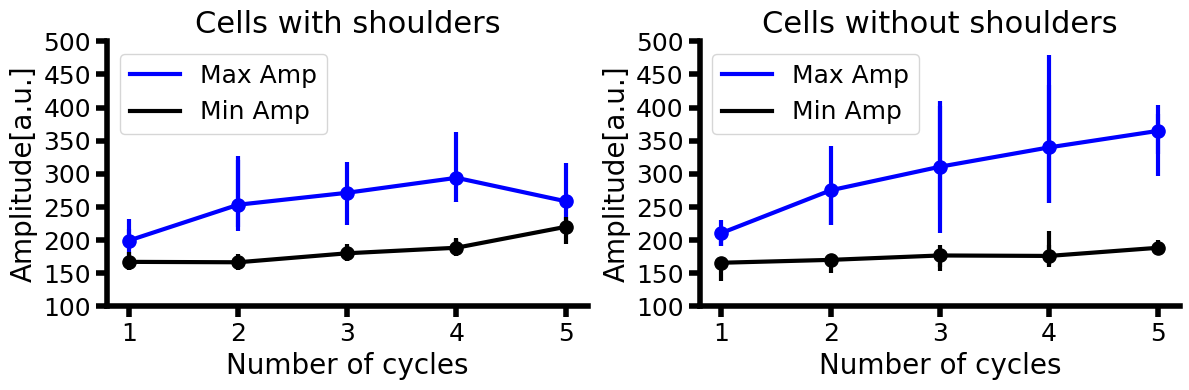

In [36]:
# Plot

fig = plt.figure(figsize=[12,4])

data_max_cycles = [max_cycle_s, max_cycle_ns]
data_min_cycles = [min_cycle_s, min_cycle_ns]
title = ['Cells with shoulders', 'Cells without shoulders']

for xp in range(2):
    
    plt.subplot(1,2,xp+1)
    max_cycle = data_max_cycles[xp]
    min_cycle = data_min_cycles[xp]
    
    # Maxima
    max_nan = []
    quartile1 = []
    quartile3 = []
    medians = []

    for i in range(max_n_cycles-2):
        aux = max_cycle[i][~np.isnan(max_cycle[i])]
        max_nan.append(aux)
        quartile1.append(np.percentile(aux, [25, 50, 75])[0])
        medians.append(np.percentile(aux, [25, 50, 75])[1])
        quartile3.append(np.percentile(aux, [25, 50, 75])[2])


    # Add medians
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(max_nan, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    # Plot ticks 
    plt.xticks(np.arange(0,max_n_cycles-2,1), np.arange(1,max_n_cycles-1,1), fontsize=16);
    plt.yticks(fontsize=16)
    plt.xlabel('Number of cycles', fontsize=18)
    plt.ylabel('Amplitude [a.u.]', fontsize=18)
    #plt.ylim([0,40])

    inds = np.arange(0, len(medians) )
    plt.plot(inds,medians, color='blue', linewidth=3, label='Max Amp')
    plt.scatter(inds, medians, marker='o', color='blue', s=90, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
    plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=3)


    # Minima

    # Remove nans for violin plot
    min_nan = []
    quartile1 = []
    quartile3 = []
    medians = []

    for i in range(max_n_cycles-2):
        aux = min_cycle[i][~np.isnan(min_cycle[i])]
        min_nan.append(aux)
        quartile1.append(np.percentile(aux, [25, 50, 75])[0])
        medians.append(np.percentile(aux, [25, 50, 75])[1])
        quartile3.append(np.percentile(aux, [25, 50, 75])[2])


    # Add medians
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(min_nan, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(0, len(medians) )
    plt.plot(inds, medians, color='black', linewidth=3, label='Min Amp')
    plt.scatter(inds, medians, marker='o', color='black', s=90, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
    plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=3)


    plt.xticks(np.arange(0,max_n_cycles-2,1), np.arange(1,max_n_cycles-1,1), fontsize=18);
    plt.yticks(fontsize=18)
    plt.xlabel('Number of cycles', fontsize=20)
    plt.ylabel('Amplitude[a.u.]', fontsize=20)
    plt.legend(loc='upper left', fontsize=18)
    plt.title('%s'%title[xp], fontsize=22)
    plt.ylim([100,500])

    ax = plt.gca()
    ax.tick_params(width=4, length=8)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(0)
    
plt.tight_layout()
plt.show()

#CH: Comment as outdir does not exist
#fig.savefig('../Data/Supplements/Figure S2/Results/MaxMinAmplitude-Bycycle-shouldersvsnoshoulders.pdf', format='pdf', bbox_inches='tight')

### Periods by cycle - shoulder cells vs no shoulder cells

In [37]:
# For shoulder cells
period_val_cycle_s = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in shoulder_cells:

    # Save the value of each period according to the cycle
    for j in range(len(periods_all[i])):
        period_val_cycle_s[j+1].append(periods_all[i][j])

# Convert into list arrays  
period_cycle_s = []

for i in range(max_n_cycles):
    period_cycle_s.append(np.array(period_val_cycle_s[i+1]))
    
# For no shoulder cells
period_val_cycle_ns = {new_list: [] for new_list in range(1,max_n_cycles+1,)}

for i in no_shoulder_cells[:-1]:

    # Save the value of each period according to the cycle
    for j in range(len(periods_all[i])):
        period_val_cycle_ns[j+1].append(periods_all[i][j])

# Convert into list arrays  
period_cycle_ns = []

for i in range(max_n_cycles):
    period_cycle_ns.append(np.array(period_val_cycle_ns[i+1]))
       

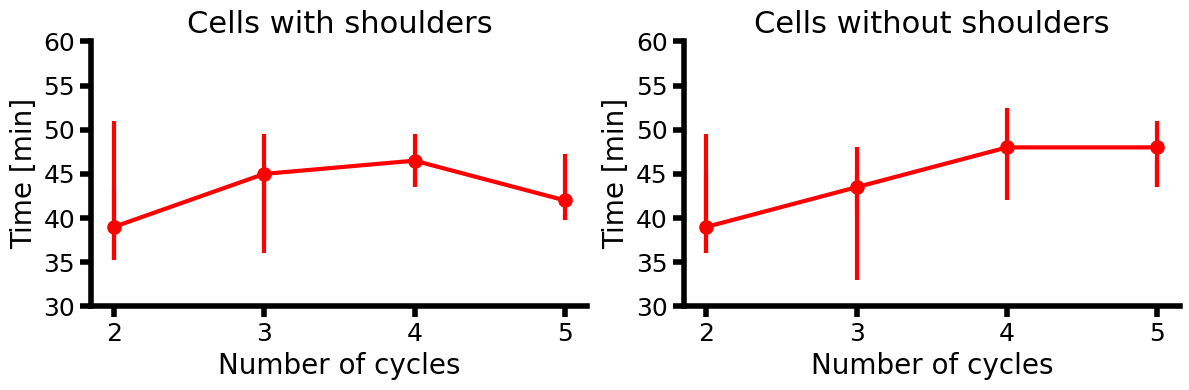

In [39]:
# Plot
fig = plt.figure(figsize=[12,4])

data_periods = [period_cycle_s, period_cycle_ns]
title = ['Cells with shoulders', 'Cells without shoulders']

for xp in range(2):
    
    plt.subplot(1,2,xp+1)
    period_cycle = data_periods[xp]

    # Maxima
    period_nan = []
    quartile1 = []
    quartile3 = []
    medians = []

    for i in range(max_n_cycles-3):
        aux = period_cycle[i][~np.isnan(period_cycle[i])]
        period_nan.append(aux)
        quartile1.append(np.percentile(aux, [25, 50, 75])[0])
        medians.append(np.percentile(aux, [25, 50, 75])[1])
        quartile3.append(np.percentile(aux, [25, 50, 75])[2])


    # Add medians
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(period_nan, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


    inds = np.arange(0, len(medians) )
    plt.plot(inds,medians, color='red', linewidth=3, label='Max Amp')
    plt.scatter(inds, medians, marker='o', color='red', s=90, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='red', linestyle='-', lw=3)
    plt.vlines(inds, whiskersMin, whiskersMax, color='red', linestyle='-', lw=3)


    plt.xticks(np.arange(0,max_n_cycles-3,1), np.arange(2,max_n_cycles-1,1), fontsize=18);
    plt.yticks(np.arange(30,65,5), fontsize=18)
    plt.ylim([30,60])
    plt.xlabel('Number of cycles', fontsize=20)
    plt.ylabel('Time [min]', fontsize=20)
    plt.title('%s'%title[xp], fontsize=22)

    ax = plt.gca()
    ax.tick_params(width=4, length=8)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()
#CH: COMMENT as outdir does not exist
#fig.savefig('../Data/Supplements/Figure S2/Results/Periods-Bycycle-shouldersvsnoshoulders.pdf', format='pdf', bbox_inches='tight')

### Ts and As calculation

In [40]:
# Remove ouliers from a list
def reject_outliers(data, m=3):
    return data[abs(data - np.nanmean(data)) < m * np.nanstd(data)]

# Find differences between two lists
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

In [41]:
T_minus_s = []
T_plus_s = []
A_minus_s = []
A_plus_s = []
n_cycles_s = []
pos_last_Tplus_s = []

T_minus_ns = []
T_plus_ns = []
A_minus_ns = []
A_plus_ns = []
n_cycles_ns = []
pos_last_Tplus_ns = []

for j in range(n_cells):
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    #peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    if len(np.where(j==np.array(shoulder_cells))[0])>0:
        T_minus_s.append(peaks.cycles_T_minus_plot)
        T_plus_s.append(peaks.cycles_T_plus_plot)
        A_minus_s.append(peaks.cycles_A_minus_plot)
        A_plus_s.append(peaks.cycles_A_plus_plot)
        n_cycles_s.append(peaks.n_cycles)
    else:
        T_minus_ns.append(peaks.cycles_T_minus_plot)
        T_plus_ns.append(peaks.cycles_T_plus_plot)
        A_minus_ns.append(peaks.cycles_A_minus_plot)
        A_plus_ns.append(peaks.cycles_A_plus_plot)
        n_cycles_ns.append(peaks.n_cycles)
        
        

#bulk_peaks = bulk_peak_analysis(T_minus, T_plus, A_minus, A_plus)

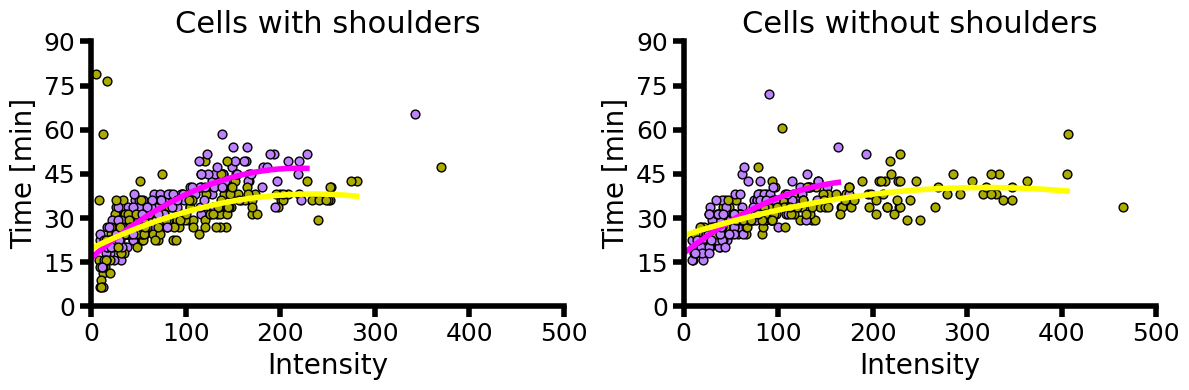

In [46]:
fig = plt.figure(figsize=[12,4])

data_cycles = [n_cycles_s, n_cycles_ns]
data_T_minus = [T_minus_s, T_minus_ns]
data_T_plus = [T_plus_s, T_plus_ns]
data_A_minus = [A_minus_s, A_minus_ns]
data_A_plus = [A_plus_s, A_plus_ns]
title = ['Cells with shoulders', 'Cells without shoulders']

for xp in range(2):
    
    plt.subplot(1,2,xp+1)
    n_cycles = data_cycles[xp]
    T_minus = data_T_minus[xp]
    T_plus = data_T_plus[xp]
    A_minus = data_A_minus[xp]
    A_plus = data_A_plus[xp]

    cycles = np.unique(list(filter(None, n_cycles)))

    purple = [191/255, 130/255, 255/255]
    yellow = [171/255, 171/255, 0/255]

    T_plus_save = []
    T_minus_save = []
    A_plus_save = []
    A_minus_save = []

    # Plot the data
    for j,val in enumerate(n_cycles):
        # Convert "cycles minus/plus plot" into a list in order to plot it
        lists1 = T_minus[j][:-1]
        lists2 = A_minus[j][:-1]
        lists3 = T_plus[j][1:]
        lists4 = A_plus[j][1:]

        merged_list1 = []
        merged_list2 = []
        merged_list3 = []
        merged_list4 = []

        for l in lists1:
            merged_list1 += l 

        for l in lists2:
            merged_list2 += l 

        for l in lists3:
            merged_list3 += l 

        for l in lists4:
            merged_list4 += l 

        T_plus_save += merged_list3
        T_minus_save += merged_list1
        A_plus_save += merged_list4
        A_minus_save += merged_list2

        if j==0:
            plt.scatter(merged_list2, np.array(merged_list1)*tr_min, s=40, alpha=1, color=purple, edgecolors='black', linewidth=1, label='T+ vs A+')
            plt.scatter(merged_list4, np.array(merged_list3)*tr_min, s=40, alpha=1, color=yellow, edgecolors='black', linewidth=1,label='Production')
        else:
            plt.scatter(merged_list2, np.array(merged_list1)*tr_min, s=40, alpha=1, edgecolors='black', linewidth=1, color=purple)
            plt.scatter(merged_list4, np.array(merged_list3)*tr_min, s=40, alpha=1, edgecolors='black', linewidth=1, color=yellow)

    # Remove outliers from the ratio array
    Am = reject_outliers(np.array(A_minus_save))
    Ap = reject_outliers(np.array(A_plus_save))
    Tm = reject_outliers(np.array(T_minus_save))
    Tp = reject_outliers(np.array(T_plus_save))

    # Outliers
    Amo = Diff(np.array(A_minus_save), Am)
    Apo = Diff(np.array(A_plus_save), Ap)
    Tmo = Diff(np.array(T_minus_save), Tm)
    Tpo = Diff(np.array(T_plus_save), Tp)

    # Remove outliers of A from T and visceversa
    minus_outliers = []
    plus_outliers = []
    for i in range(len(Tmo)):
        minus_outliers.append(np.where(np.array(T_minus_save) == Tmo[i])[0][0])

    for i in range(len(Amo)):
        minus_outliers.append(np.where(np.array(A_minus_save) == Amo[i])[0][0])

    for i in range(len(Tpo)):
        plus_outliers.append(np.where(np.array(T_plus_save) == Tpo[i])[0][0])

    for i in range(len(Apo)):
        plus_outliers.append(np.where(np.array(A_plus_save) == Apo[i])[0][0])

    # Remove the outliers from both :
    x1 = np.delete(A_minus_save, minus_outliers)
    x2 = np.delete(A_plus_save, plus_outliers)
    y1 = np.delete(T_minus_save, minus_outliers)*tr_min
    y2 = np.delete(T_plus_save, plus_outliers)*tr_min


    # Fit a 2nd degree polynomial 
    xp1 = np.linspace(0,max(x1),400)
    xp2 = np.linspace(0,max(x2),400)

    pol_degree = 2

    z1 = np.polyfit(x1, y1, pol_degree)
    z2 = np.polyfit(x2, y2, pol_degree)

    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)

    # Fitting line plots
    plt.plot(xp1, p1(xp1), color='magenta', linewidth=4)
    plt.plot(xp2, p2(xp2), color='yellow', linewidth=4)

    plt.ylabel('Time [min]', fontsize=20)
    plt.xlabel('Intensity', fontsize=20)
    locs, labels = plt.yticks()
    #plt.legend(loc='best', fontsize=16)
    plt.yticks([0,10,20,30,40,50,60],  map(int,np.array([0,10,20,30,40,50,60])*tr_min) ,fontsize=18)
    plt.xticks(np.arange(0,600,100), fontsize=18)
    plt.ylim([0,60])
    plt.xlim([0,500])

    ax = plt.gca()
    ax.tick_params(width=4, length=8)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(0)
    plt.title('%s'%title[xp], fontsize=22)

plt.tight_layout()
plt.show()
#CH: comment as outdir does not exist
#fig.savefig('../Data/Supplements/Figure S2/Results/TimeVsAmp-invivo-PosAll-shouldersvsnoshoulders.pdf', format='pdf')

### Ts by cycle

In [47]:
# Arange by cycles

# Convert into list arrays  
A_plus_cycle_s = []
A_minus_cycle_s = []
T_plus_cycle_s = []
T_minus_cycle_s = []
A_plus_cycle_ns = []
A_minus_cycle_ns = []
T_plus_cycle_ns = []
T_minus_cycle_ns = []

for xp in range(2):
    n_cycles = data_cycles[xp]
    T_minus = data_T_minus[xp]
    T_plus = data_T_plus[xp]
    A_minus = data_A_minus[xp]
    A_plus = data_A_plus[xp]

    T_plus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)} 
    T_minus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}
    A_plus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}
    A_minus_by_cycle = {new_list: [] for new_list in range(1,max(n_cycles)+1,)}

    # Plot the data
    for j,val in enumerate(n_cycles):
        # Convert "cycles minus/plus plot" into a list in order to plot it
        lists1 = T_minus[j][:-1]
        lists2 = A_minus[j][:-1]
        lists3 = T_plus[j][1:]
        lists4 = A_plus[j][1:]

        for i in range(val-1):
            T_plus_by_cycle[i+1].append(lists3[i][0])
            T_minus_by_cycle[i+1].append(lists1[i][0])
            A_plus_by_cycle[i+1].append(lists4[i][0])
            A_minus_by_cycle[i+1].append(lists2[i][0])


    if xp == 0:
        for i in range(max(n_cycles)):
            A_plus_cycle_s.append(np.array(A_plus_by_cycle[i+1]))
            A_minus_cycle_s.append(np.array(A_minus_by_cycle[i+1]))
            T_plus_cycle_s.append(np.array(T_plus_by_cycle[i+1]))
            T_minus_cycle_s.append(np.array(T_minus_by_cycle[i+1]))
    else:
        for i in range(max(n_cycles)):
            A_plus_cycle_ns.append(np.array(A_plus_by_cycle[i+1]))
            A_minus_cycle_ns.append(np.array(A_minus_by_cycle[i+1]))
            T_plus_cycle_ns.append(np.array(T_plus_by_cycle[i+1]))
            T_minus_cycle_ns.append(np.array(T_minus_by_cycle[i+1]))

    

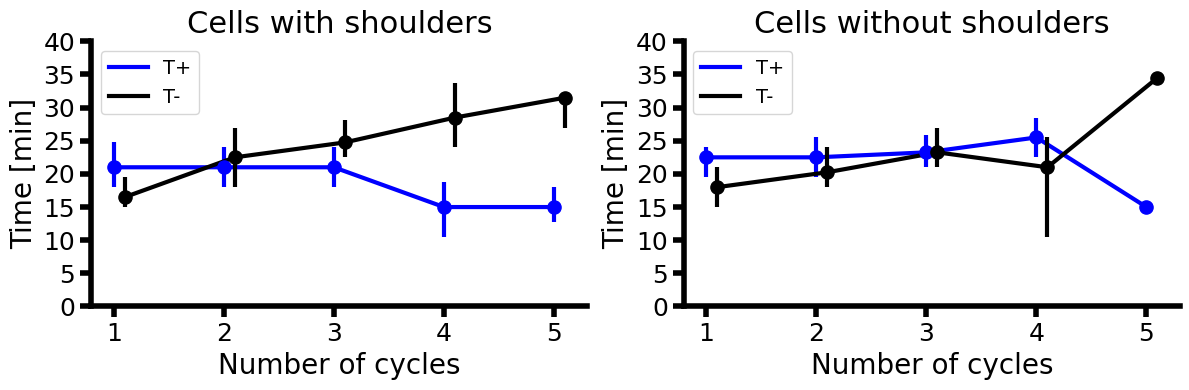

In [49]:
fig = plt.figure(figsize=[12,4])

data_T_minus = [T_minus_cycle_s, T_minus_cycle_ns]
data_T_plus = [T_plus_cycle_s, T_plus_cycle_ns]
    
for xp in range(2):
    plt.subplot(1,2,xp+1)
    
    n_cycles = data_cycles[xp]
    T_minus_cycle = data_T_minus[xp]
    T_plus_cycle = data_T_plus[xp]

    
    #  T +
    # Remove nans for violin plot
    T_plus_nan = []
    quartile1 = []
    quartile3 = []
    medians = []
    
    n_cycles_all = max(n_cycles)-1

        
    
        
    for i in range(n_cycles_all-1):
        aux = T_plus_cycle[i][~np.isnan(T_plus_cycle[i])]*tr_min
        T_plus_nan.append(aux)
        quartile1.append(np.percentile(aux, [25, 50, 75])[0])
        medians.append(np.percentile(aux, [25, 50, 75])[1])
        quartile3.append(np.percentile(aux, [25, 50, 75])[2])

    medians_plus = medians

    # Add medians
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(T_plus_nan, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    # Plot ticks 
    plt.xticks(np.arange(0,n_cycles_all-1,1), np.arange(1,n_cycles_all,1), fontsize=16);
    plt.yticks(fontsize=16)
    plt.xlabel('Number of cycles', fontsize=18)
    plt.ylabel('T+ [min]', fontsize=18)
    plt.ylim([0,40])

    inds = np.arange(0, len(medians) )
    plt.plot(inds,medians, color='blue', linewidth=3, label='T+')
    plt.scatter(inds, medians, marker='o', color='blue', s=90, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='blue', linestyle='-', lw=3)
    #plt.vlines(inds, whiskersMin, whiskersMax, color='blue', linestyle='-', lw=2)


    # T -

    # Remove nans for violin plot
    T_minus_nan = []
    quartile1 = []
    quartile3 = []
    medians = []

    for i in range(n_cycles_all-1):
        aux = T_minus_cycle[i][~np.isnan(T_minus_cycle[i])]*tr_min
        T_minus_nan.append(aux)
        quartile1.append(np.percentile(aux, [25, 50, 75])[0])
        medians.append(np.percentile(aux, [25, 50, 75])[1])
        quartile3.append(np.percentile(aux, [25, 50, 75])[2])

    medians_minus = medians

    # Add medians
    whiskers = np.array([adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(T_minus_nan, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(0, len(medians) )+0.1
    plt.plot(inds, medians, color='black', linewidth=3, label='T-')
    plt.scatter(inds, medians, marker='o', color='black', s=90, zorder=3)
    plt.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=3)
    #plt.vlines(inds, whiskersMin, whiskersMax, color='black', linestyle='-', lw=2)

    # Plot ticks 
    plt.xticks(np.arange(0,n_cycles_all-1,1), np.arange(1,n_cycles_all,1), fontsize=18);
    plt.yticks(fontsize=18)
    plt.xlabel('Number of cycles', fontsize=20)
    plt.ylabel('Time [min]', fontsize=20)
    plt.legend(fontsize=14)
    plt.ylim([0,40])
    ax = plt.gca()
    ax.tick_params(width=4, length=8)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(0)
    plt.title('%s'%title[xp], fontsize=22)

plt.tight_layout()

plt.show()
#CH: Comment as outdir does not exist
#fig.savefig('../Data/Supplements/Figure S2/Results/Ts-Bycycle-shouldersvsnoshoulders.pdf', format='pdf', bbox_inches='tight')

## Edit .xml file - observe the shoulder cells

In [50]:
from xml.etree.ElementTree import ElementTree
from io import BytesIO

In [51]:
# Open the  XML file of your original data to write and edit
# Then we will save and edit a new xml file

path_xml = '../Data/Supplements/Figure S2/Position2_PSMd_20191213_checked_ABR_mamut.xml'
tree = ElementTree()
tree.parse(path_xml)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Supplements/Figure S2/Position2_PSMd_20191213_checked_ABR_mamut.xml'

In [ ]:
# XML Declaration

f = BytesIO()
tree.write(f, encoding='utf-8', xml_declaration=True) 

In [ ]:
# Correct the units
units = 'µm'
for TrackMate in tree.iter('TrackMate'):
    for Model in TrackMate.iter('Model'):
        # Change value
        Model.set('spatialunits', '%s'%units)

### Tracks you want to keep and the ones youw ant to remove

In [ ]:
# Align using their temporal position

# First find the experiment with the maximum number of frames
# Then compute the number of total cells in all experiments

n_frames = 0
for i in range(n_cells):
    if np.max(tracks2.spots_features['Frames'][i])>n_frames:
        n_frames = np.max(tracks2.spots_features['Frames'][i])

n_cells =  tracks2.n_tracks_divs

# Save all the cells from all the experiments in the same array 
tracks_save = np.ones((n_cells, n_frames+1))*np.nan
ids_save = np.ones((n_cells, n_frames+1))*np.nan

count = 0

# For each track 
for i in range(n_cells):

    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(tracks2.spots_features["Frames"][i]):
        tracks_save[i,val] = tracks2.spots_features["Mean1"][i][j]
        ids_save[i,val] = tracks2.spots_features["ID"][i][j]


In [ ]:
# Peak detection parameters
ind = 0 #8 
# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

# If you want ts and as analysis: 'ts_as', ow no_ts_as
analysis = 'ts_as'

# Define the dimensions of the subplot
n_cols =  4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[10,50])

max_peaks_all = []
min_peaks_all = []
max_val_all = []
min_val_all = []
periods_all = []

# To obtain the maximum number of cycles
max_n_cycles = 0

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(n_rows, n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_, analysis)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    #peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    if np.isnan(y[peaks.peaks_][0]):
        peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    
    # Save peaks (in time)
    max_peaks_all.append((peaks.peaks+window/2)*tr_min)
    min_peaks_all.append((peaks.peaks_+window/2)*tr_min)
    
    # Save maxima intensity
    max_val_all.append(y[peaks.peaks])
    
    # Save minima
    min_val_all.append(y[peaks.peaks_][:-1])
    
    # Save periods
    if len(peaks.peaks)>1:
        periods_all.append(np.diff(peaks.peaks)*tr_min)
    
    if len(peaks.peaks)>max_n_cycles:
        max_n_cycles = len(peaks.peaks)
        
    plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    #plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    #plt.ylabel('Mean Intensity', fontsize=16)
    plt.xlim([0,200])
    plt.ylim([100,600])


plt.tight_layout()
plt.show()

In [ ]:
shoulder_cells = []
no_shoulder_cells = []


for i in range(n_cells):
    # First check there is at least two peaks:
    if len(amplitudes[i])>1:
        
        # if last amplitude is smaller than the second to last, it is a shoulder
        if amplitudes[i][-1]<amplitudes[i][-2]:
            shoulder_cells.append(i)

        # Otherwise, there is no shoulder
        else:
            no_shoulder_cells.append(i)
    else:
        no_shoulder_cells.append(i)

### Change the xml file

In [ ]:
# Spots and tracks to remove
spots_to_remove = []
tracks_to_remove = []

for i in range(len(no_shoulder_cells)):
    spots_to_remove += list(tracks2.spots_features['ID'][no_shoulder_cells[i]])# All the spots you want to remove
    tracks_to_remove.append(tracks2.spots_features['ID'][no_shoulder_cells[i]][0])# All the spots you want to remove
    
# Conver to array otherwise I cannot use np.where later
spots_to_remove = np.array(spots_to_remove)
tracks_to_remove = np.array(tracks_to_remove)

In [ ]:
len(spots.n_spots)-len(spots_to_remove)

In [ ]:
n_spots_left = len(spots.n_spots)-len(spots_to_remove)

# First thing to change is "nspots":
for Model in tree.iter('Model'):
    for AllSpots in Model.iter('AllSpots'):
        # Change value
        AllSpots.set('nspots', '%d'%n_spots_left)

In [ ]:
import time

In [ ]:
t = time.time()    

# Delete the Spots that are no longer in the tracks of interest
for SpotsInFrame in tree.iter('SpotsInFrame'):
    for Spot in SpotsInFrame.findall('Spot'):
        if len(np.where(int(Spot.attrib['ID'])==spots_to_remove)[0])>0:
            SpotsInFrame.remove(Spot)

print(time.time() - t)

In [ ]:
# Remove all the TrackIDs: The first spot ID from each track
for AllTracks in tree.iter('AllTracks'):
    for Track in AllTracks.findall('Track'):
        if len(np.where(int(Track.attrib['TRACK_ID']) == tracks_to_remove)[0])>0:
            AllTracks.remove(Track)
            

# Remove all the FilteredTracks: The first spot ID from each track  

for FilteredTracks in tree.iter('FilteredTracks'):
    for TrackID in FilteredTracks.findall('TrackID'):
        if len(np.where(int(TrackID.attrib['TRACK_ID']) == tracks_to_remove)[0])>0:
            FilteredTracks.remove(TrackID)   
           
            
tree.write('../Data/Supplements/Figure S2/output_Pos2.xml')
elapsed = time.time() - t
print('Time in seconds: %d'%elapsed)

## Gullum vs Control: Is the clock necessary for Mesp onset?

Using all in vitro data we have 4 experiments in which we compare the levels of Mesp in a control case versus a Gullum (Her1-Her7 mutant). The area for both cases is the PSM4. 

In [ ]:
exp_names

In [ ]:
# Fluorescent traces of mKate and YFP signals
all_exps = pd.ExcelFile('../Data/Supplements/Figure S2/gu_vs_control_cells.xlsx')
exp_names = all_exps.sheet_names

cells_id_control = []
cells_id_gullum = []
intensities_control = []
intensities_gullum = []

# Temporal resolution
tr = 10 # minutes

for i in exp_names[2:]:
    # Each experiment is in a separate sheet in the .xlsx file
    
    # Look for mkate of yfp signals in the excel file sheet names
    substring1 = 'control'
    substring2 = 'gullum'
    
    
    # If the name contains control, it is a mesp intensity from the control group
    if i.find(substring1)!= (-1):
        
        
        mesp_intensities = pd.read_excel('../Data/Supplements/Figure S2/gu_vs_control_cells.xlsx',sheet_name=i)
        # Cell ID
        aux_id = np.array(mesp_intensities.keys())
        aux_mesp = []
        
        # Save the intensities for each cell "j" in experiment "i"
        for j in aux_id:
            aux_mesp.append(np.array(mesp_intensities[j]))
        
        intensities_control.append(aux_mesp)
        cells_id_control.append(aux_id)
    
    # If the name contains gullum, it is a mesp intensity from the gullum group
    if i.find(substring2)!= (-1):
        
        
        mesp_intensities = pd.read_excel('../Data/Supplements/Figure S2/gu_vs_control_cells.xlsx',sheet_name=i)
    
        # Cell ID
        aux_id = np.array(mesp_intensities.keys())
        
        aux_mesp = []
        # Save the intensities for each cell "j" in experiment "i"
        for j in aux_id:
            aux_mesp.append(np.array(mesp_intensities[j]))
    
        intensities_gullum.append(aux_mesp)
        cells_id_gullum.append(aux_id)


n_experiments = len(intensities_gullum)

### Plot the mesp traces

In [ ]:
# Plot all Mesp tracks for each experiment separately

# Define the dimensions of the subplot

# Initialize the figure size
fig = plt.figure(figsize=[14,8])

for j in range(n_experiments):
    
    # Update the number of subplots    
    plt.subplot(2,3,j+1)
    
    for i in range(len(cells_id_control[j])):
        plt.plot(intensities_control[j][i], color='blue', linewidth=0.2)
        plt.xlim([0,80])
        plt.xticks(np.arange(0,100,20), map(int, np.arange(0,100,20)*tr), fontsize=14)
        plt.yticks(fontsize=16)
        plt.ylim([380,700])
        plt.xlabel('Time [minutes]', fontsize=16)
        plt.ylabel('Intensity [a.u.]', fontsize=16)
        plt.title('Experiment # %d'%(j+1), fontsize=20)
        ax = plt.gca()
        ax.tick_params(width=4, length=8)
        ax.spines['top'].set_linewidth(0)
        ax.spines['bottom'].set_linewidth(4)
        ax.spines['left'].set_linewidth(4)
        ax.spines['right'].set_linewidth(0)
    
for j in range(n_experiments):
    
    # Update the number of subplots    
    plt.subplot(2,3,j+1+3)
    
    for i in range(len(cells_id_gullum[j])):
        plt.plot(intensities_gullum[j][i], color='blue', linewidth=0.2)
        plt.xlim([0,80])
        plt.xticks(np.arange(0,100,20), map(int, np.arange(0,100,20)*tr), fontsize=14)
        plt.yticks(fontsize=16)
        plt.ylim([380,700])
        plt.xlabel('Time [minutes]', fontsize=16)
        plt.ylabel('Intensity [a.u.]', fontsize=16)
        plt.title('Experiment # %d'%(j+1), fontsize=20)
        ax = plt.gca()
        ax.tick_params(width=4, length=8)
        ax.spines['top'].set_linewidth(0)
        ax.spines['bottom'].set_linewidth(4)
        ax.spines['left'].set_linewidth(4)
        ax.spines['right'].set_linewidth(0)
     
    
plt.tight_layout()
plt.show()

fig.savefig('../Data/Supplements/Figure S2/Results/MespPerExperimentTraces-GullumControl.pdf', format='pdf', bboxes_inches='tight')

### Calculate Mesp fold change

In [ ]:
# How many points to take into account for the average of Area 1 and 2

exp = 0

# We will only consider traces which are at least 60 timepoints
# We will then crop them so that they start at 0 and end up at 60
len_traces1 = 0
len_traces2 = 60
len_traces = len_traces1+len_traces2

def ratio_mesp(window, intensities):
        
    # Compute the areas
    area1 = np.abs(np.mean(intensities[:window]))
    area2 = np.mean(intensities[-window:])

    # Compute the ratio
    ratio = area2 - area1
    
    return ratio

# Compute the ratio: Area 2 - Area 1 
ratio_control = []
ratio_gullum = []

# Save the intensities without grouping them by experimeng
intensities_control_all = []
intensities_gullum_all = []

# Window size to get values at the beginning and at the end of the traces to make the raito
window = 5

for j in range(len(intensities_control)):
    for i in range(len(intensities_control[j])):

            # Intensity values of Mesp tracks
            intensities = intensities_control[j][i]

            # Remove nans
            intensities = intensities[~np.isnan(intensities)]
            
            # If all the values are nan, ignore. Otherwise calculate the ratio
            if all(np.isnan(intensities)) == False and len(intensities)>=len_traces:
                ratio_control.append(ratio_mesp(window, intensities[len_traces1:len_traces2]))
                intensities_control_all.append(intensities[len_traces1:len_traces2])

for j in range(len(intensities_gullum)):
    for i in range(len(intensities_gullum[j])):

            # Intensity values of Mesp tracks
            intensities = intensities_gullum[j][i]

            # Remove nans
            intensities = intensities[~np.isnan(intensities)]
            
            # If all the values are nan, ignore. Otherwise calculate the ratio
            if all(np.isnan(intensities)) == False and len(intensities)>=len_traces:

                ratio_gullum.append(ratio_mesp(window, intensities[len_traces1:len_traces2]))
                intensities_gullum_all.append(intensities[len_traces1:len_traces2])

#### Plot the cropped mesp traces

In [ ]:
# Plot all Mesp tracks for each experiment separately

window = 5

# Initialize the figure size
fig = plt.figure(figsize=[12,4])

plt.subplot(121)
for i in range(len(intensities_control_all)):
    plt.plot(intensities_control_all[i], color='blue', linewidth=0.2)
plt.xticks(np.arange(0,len_traces2-len_traces1+10,10), map(int, np.arange(0,len_traces2-len_traces1+10,10)*tr), fontsize=18)
plt.xlim([0,len_traces2-len_traces1])
plt.ylim([380,700])
plt.yticks(fontsize=18)
plt.xlabel('Time [minutes]', fontsize=20)
plt.ylabel('Intensity [a.u.]', fontsize=20)
plt.title('Control', fontsize=25)
      
plt.axvline(window, color='red', linewidth=2, linestyle='--')
plt.axvline((len_traces2-len_traces1)-window, color='red', linewidth=2, linestyle='--')

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
for i in range(len(intensities_gullum_all)):
    plt.plot(intensities_gullum_all[i], color='blue', linewidth=0.2)
plt.xticks(np.arange(0,len_traces2-len_traces1+10,10), map(int, np.arange(0,len_traces2-len_traces1+10,10)*tr), fontsize=18)
plt.xlim([0,len_traces2-len_traces1])
plt.ylim([380,700])
plt.yticks(fontsize=18)
plt.xlabel('Time [minutes]', fontsize=20)
plt.ylabel('Intensity [a.u.]', fontsize=20)
plt.title('Gullum', fontsize=25)
      
plt.axvline(window, color='red', linewidth=2, linestyle='--')
plt.axvline((len_traces2-len_traces1)-window, color='red', linewidth=2, linestyle='--')

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()


plt.show()

fig.savefig('../Data/Supplements/Figure S2/Results/MespCropped-GullumvsControl.pdf', format='pdf', bboxes_inches='tight')




#### Plot the fold change for all the mesp traces - gullum vs control

In [ ]:
# Distributions

fig = plt.figure(figsize=[12,4])

plt.subplot(121)
plt.hist(ratio_control, edgecolor='black', color='gray', bins='fd', linewidth=2)
plt.xlabel('Fold Change [a.u.]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Control', fontsize=25)
plt.xticks(np.arange(0,1000,200), np.arange(0,100,20), fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([-10,600])
plt.ylim([0,20])

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.subplot(122)
plt.hist(ratio_gullum, edgecolor='black', color='gray', bins='fd', linewidth=2)
plt.xlabel('Fold Change [a.u.]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Gullum', fontsize=25)
plt.xticks(np.arange(0,1000,200), np.arange(0,100,20), fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([-10,600])
plt.ylim([0,20])

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Supplements/Figure S2/Results/FoldChangeMesp-AllCells-GullumvsControl.pdf', format='pdf', bboxes_inches='tight')

### Classify using K-Means

In [ ]:
# Distributions
color1 = ['royalblue', 'deepskyblue', 'navy']
color2 = ['deepskyblue','royalblue','navy']

fig = plt.figure(figsize=[8,6])

n_clusters = 3

plt.subplot(221)
window = 5
count = 0

ratio = np.array(ratio_control)
X = np.array(ratio).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)
group1 = np.where(y_pred==1)[0]
group2 = np.where(y_pred==2)[0]

val1 = np.min(ratio[group1])
val2 = np.min(ratio[group2])

for i in range(len(intensities_control_all)):   
    plt.plot(intensities_control_all[i], c=color1[y_pred[count]],alpha=0.5, linewidth=2) 
    count+=1
        
plt.axvline(window, color='red', linewidth=2, linestyle='--')
plt.axvline((len_traces2-len_traces1)-window, color='red', linewidth=2, linestyle='--')

plt.xlabel('Time [min]',fontsize=20)
plt.title('Control', fontsize=25)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,(len_traces2-len_traces1)+20,20), np.arange(0,(len_traces2-len_traces1)+20,20)*tr, fontsize=20)
plt.xlim([0,len_traces2-len_traces1])
plt.ylim([380,600])
plt.yticks(fontsize=18)
plt.ylabel('Intensity',fontsize=18)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(222)
window = 5
count = 0

ratio = np.array(ratio_gullum)
X = np.array(ratio).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

for i in range(len(intensities_gullum_all)):   
    plt.plot(intensities_gullum_all[i], c=color2[y_pred[count]],alpha=0.5, linewidth=2) 
    count+=1
        
plt.axvline(window, color='red', linewidth=2, linestyle='--')
plt.axvline(len_traces-window, color='red', linewidth=2, linestyle='--')

plt.xlabel('Time [min]',fontsize=20)
plt.title('Gullum', fontsize=25)
locs, labels = plt.xticks()
plt.xticks(np.arange(0,(len_traces2-len_traces1)+20,20), np.arange(0,(len_traces2-len_traces1)+20,20)*tr, fontsize=20)
plt.xlim([0,len_traces2-len_traces1])
plt.ylim([380,600])
plt.yticks(fontsize=18)
plt.ylabel('Intensity',fontsize=18)
#plt.title('Window size = %d'%window, fontsize=20)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(223)

ratio = np.array(ratio_control)
X = np.array(ratio).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio[np.where(y_pred==0)[0]])
max2 = np.max(ratio[np.where(y_pred==1)[0]])
max3 = np.max(ratio[np.where(y_pred==2)[0]])


# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[:2]

# Find the positions where those values are in the ratio
ind_mesp_control = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))

group1 = np.where(y_pred==1)[0]
group2 = np.where(y_pred==2)[0]

val1 = np.min(ratio[group1])
val2 = np.min(ratio[group2])

plt.hist(ratio, edgecolor='black', color='gray', bins='fd', linewidth=2)
#plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
#plt.axvline(val2, color='red', linewidth=3, alpha=0.5)
N, bins, patches = plt.hist(ratio, edgecolor='black', linewidth=2, bins='fd')
#plt.hist(ratio, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color1[1])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color1[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color1[0])

plt.xlabel('Fold Change', fontsize=20)
plt.ylabel('Number of cells', fontsize=20)
plt.xticks(np.arange(0,300,75), fontsize=18)
plt.yticks(np.arange(0,25,5), fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.subplot(224)

ratio = np.array(ratio_gullum)
X = np.array(ratio).reshape(-1, 1)
X[np.where(np.isnan(X))] = 0 # In case there is any nan
y_pred = KMeans(n_clusters=n_clusters, n_init=200, random_state=1).fit_predict(X)

# Find the maximum fold change for each group
max1 = np.max(ratio[np.where(y_pred==0)[0]])
max2 = np.max(ratio[np.where(y_pred==1)[0]])
max3 = np.max(ratio[np.where(y_pred==2)[0]])

# Find the two groups where the fold change is highest
inds = np.argsort([max1,max2,max3])[:2]

# Find the positions where those values are in the ratio
ind_mesp_gullum = np.concatenate((np.where(y_pred==inds[0])[0], \
                           np.where(y_pred==inds[1])[0]))

group1 = np.where(y_pred==1)[0]
group2 = np.where(y_pred==2)[0]

val1 = np.min(ratio[group1])
val2 = np.min(ratio[group2])

plt.hist(ratio, edgecolor='black', color='gray', bins='fd', linewidth=2)
#plt.axvline(val1, color='red', linewidth=3, alpha=0.5)
#plt.axvline(val2, color='red', linewidth=3, alpha=0.5)
N, bins, patches = plt.hist(ratio, edgecolor='black', linewidth=2, bins='fd')
#plt.hist(ratio, edgecolor='black', color='gray', bins='fd', linewidth=2)
ind1 = np.argmin((val1-bins)**2)
ind2 = np.argmin((val2-bins)**2)

for i in range(0,ind2):
    patches[i].set_facecolor(color2[0])
for i in range(ind2,ind1):    
    patches[i].set_facecolor(color2[2])
for i in range(ind1, len(patches)):
    patches[i].set_facecolor(color2[1])

plt.xlabel('Fold Change', fontsize=20)
plt.ylabel('Number of cells', fontsize=20)
plt.xticks(np.arange(0,300,75), fontsize=18)
plt.yticks(np.arange(0,25,5), fontsize=18)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Supplements/Figure S2/Results/ClusteredKMeans-FoldChangeMesp-GullumvsControl.pdf', format='pdf', bbox_inches='tight')

### Calculate Mesp onset

For this we wonly use cells in the two groups where the fold change is higher.

In [ ]:
lag_window = 5
color = ['navy', 'deepskyblue', 'royalblue']

intensities = [intensities_control_all, intensities_gullum_all]
ind_mesp = [ind_mesp_control, ind_mesp_gullum]

mesp_onset = []
# For gullum and control, calculate the mesp onset
for exp in range(2):
    
    mesp_onset_aux = []
    
    for i in ind_mesp[exp]:

        X = np.zeros((len(intensities[exp][i][window:]),2))
        X[:,0] = intensities[exp][i][window:]
        X[:,1] = intensities[exp][i][:-window]
        y_pred = KMeans(n_clusters=2, n_init=100).fit_predict(X)


        ind_cut = np.where(y_pred[lag_window:]==y_pred[-1])[0]+lag_window
        mesp_onset_aux.append(ind_cut[0]*tr)

    mesp_onset.append(mesp_onset_aux)

In [ ]:
fig = plt.figure(figsize=[12,4])

plt.subplot(121)
onset_mesp = np.array(mesp_onset[0])
plt.hist(onset_mesp, bins='fd', linewidth=2, edgecolor='black', color='deepskyblue', alpha=0.8, density=False);

# Mean values plotted as dashed lines
#plt.axvline(160, color='darkblue', linewidth=4, linestyle='--', alpha=1)
#plt.axvline(np.mean(last_peak), color='darkgreen', linewidth=4, linestyle='--', alpha=1)


plt.xlabel('Time [min]',fontsize=20)
plt.ylabel('Number of cells',fontsize=20)
plt.xticks(np.arange(0,700,100), fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,600])
#plt.ylim([0,1])

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)
plt.title('Control', fontsize=25)

plt.subplot(122)
onset_mesp = np.array(mesp_onset[1])
plt.hist(onset_mesp, bins='fd', linewidth=2, edgecolor='black', color='deepskyblue', alpha=0.8, density=False);

# Mean values plotted as dashed lines
#plt.axvline(160, color='darkblue', linewidth=4, linestyle='--', alpha=1)
#plt.axvline(np.mean(last_peak), color='darkgreen', linewidth=4, linestyle='--', alpha=1)


plt.xlabel('Time [min]',fontsize=20)
plt.ylabel('Number of cells',fontsize=20)
plt.xticks(np.arange(0,700,100), fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0,600])
#plt.ylim([0,1])
plt.title('Gullum', fontsize=25)

ax = plt.gca()
ax.tick_params(width=4, length=8)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()
#fig.savefig('../Data/Figure 2/Figure 2B/Results/MespOnset.pdf', format='pdf', bbox_inches='tight')

### Align by the onset of Mesp